#Loading dependencies

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.datasets import mnist
import matplotlib.pyplot as plt
import skimage
import sklearn

#Naive image classification

## Loading MNIST data from Keras

In [2]:
dataset = mnist.load_data()
(x_train, y_train), (x_test, y_test) = dataset

In [3]:
print(f"Number of train samples - {x_train.shape[0]}")
print(f"Number of test samples - {x_test.shape[0]}")
print(f"Data shape - {x_train[1].shape}")

Number of train samples - 60000
Number of test samples - 10000
Data shape - (28, 28)


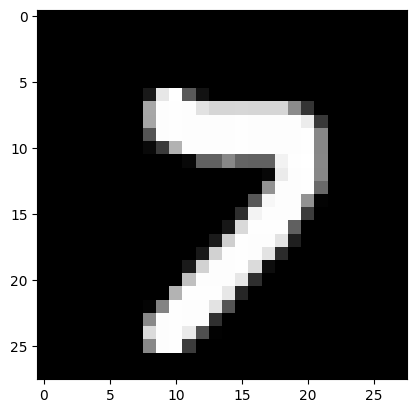

In [4]:
random_index = np.random.randint(x_train.shape[0], size = 1)
plt.imshow(x_train[random_index].squeeze(), cmap = 'grey');

In [5]:
x_train[random_index]

array([[[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0

Since the image is in uint8, we need to convert the images to float.

In [6]:
x_train = x_train/255.0
x_test = x_test/255.0

Now the 2D representation cannot be processed by Scikit-learn or by linear layers. So lets try and reshape it into 1D array and hope that the model learns.

In [7]:
x_train = x_train.reshape([x_train.shape[0], -1])
x_test = x_test.reshape([x_test.shape[0], -1])
print(x_test.shape,"\n",x_train.shape)

(10000, 784) 
 (60000, 784)


In [8]:
print(f"New data shape - {x_train[1].shape}")

New data shape - (784,)


In [9]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = (x_train - x_train.mean(axis = 0, keepdims = True))/(x_train.std(axis = 0, keepdims = True) + 1e-4)
x_test = (x_test - x_test.mean(axis = 0, keepdims = True))/(x_test.std(axis = 0, keepdims = True) + 1e-4)

##Fitting Scikit-Learn's logistic regressor

In [10]:
model = sklearn.linear_model.LogisticRegression(C=100, fit_intercept=True, solver='lbfgs', max_iter=1000)
model = model.fit(x_train, y_train)
y_predict = model.predict(x_test)

acc_training = np.mean(y_train == model.predict(x_train))*100
acc_testing = np.mean(y_test == y_predict)*100
print("Training accuracy (%) =", acc_training)
print("Testing accuracy (%) =", acc_testing)

Training accuracy (%) = 94.39999999999999
Testing accuracy (%) = 92.03


## Fitting neural network classifier

In [11]:
class Classifier(nn.Module):
  def __init__(self, input_dim = 784, output_dim = 10):
    super().__init__()
    self.layer1 = nn.Linear(input_dim, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, output_dim)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)

    return x

In [12]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


In [13]:
x_train, y_train = torch.tensor(x_train, device = device), torch.tensor(y_train, device = device)
x_test, y_test = torch.tensor(x_test, device = device), torch.tensor(y_test, device = device)

In [14]:
classifier = Classifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 100

for epoch in range(epochs):
  y_predict = classifier(x_train).squeeze()
  loss = loss_fn(y_predict, y_train)
  predicted_classes = y_predict.argmax(dim=1)
  correct = (predicted_classes == y_train).sum().item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1)%10 == 0:
    print(f"Epoch {epoch + 1} | Loss - {loss} | Accuracy - {correct/x_train.shape[0]}")

classifier.eval()
y_predict = classifier(x_test)
predicted_classes = y_predict.argmax(dim=1)
correct = (predicted_classes == y_test).sum().item()
print(f"\nTest loss - {loss_fn(y_predict, y_test)} | Accuracy - {correct/x_test.shape[0]}")

Epoch 10 | Loss - 0.4605381488800049 | Accuracy - 0.8640333333333333
Epoch 20 | Loss - 0.2501206398010254 | Accuracy - 0.9271666666666667
Epoch 30 | Loss - 0.17039458453655243 | Accuracy - 0.9481166666666667
Epoch 40 | Loss - 0.12758012115955353 | Accuracy - 0.96085
Epoch 50 | Loss - 0.09949803352355957 | Accuracy - 0.9697
Epoch 60 | Loss - 0.07910536974668503 | Accuracy - 0.9761333333333333
Epoch 70 | Loss - 0.0636945441365242 | Accuracy - 0.9812
Epoch 80 | Loss - 0.051441170275211334 | Accuracy - 0.9846333333333334
Epoch 90 | Loss - 0.04144173860549927 | Accuracy - 0.9883
Epoch 100 | Loss - 0.03324645757675171 | Accuracy - 0.9913166666666666

Test loss - 0.14603887498378754 | Accuracy - 0.9691


### Details on the implementation

#### Cross entropy loss (logits vs probabilities)

Cross entropy loss for any sample, i, is defined as -

$$H_i = -\sum_{c} p_{true}(c)*log(p_{predicted}(c)) $$

Here c represents a class.

Please note that this is different compared to binary cross entropy loss because of the way values are stored in binary classification. For more information go through this article - https://www.geeksforgeeks.org/what-is-cross-entropy-loss-function/

Now coming back to the point. The formula uses probabilities. However, our model outputs logits ranging $(-∞, ∞)$.

In [15]:
y_predict = classifier(x_train).squeeze()
print("Max value - ", y_predict.max().item())
print("Min value - ", y_predict.min().item())

Max value -  97.9786376953125
Min value -  -137.9022216796875


If you remember from lab 5, to convert logits to probabilities, we need to apply a sigmoid function (for binary classes) and softmax function (for multiclass). But in this implementation we did not use any softmax function. Then how is this working?

The answer is that PyTorch expects this. It allows the cross entropy loss to work like - `loss_instance(logits, true_class)`. This is allowed to save time.

It allows you to skip two lines of code -

In [16]:
#converting logits to probabilities
y_predict_prob = F.softmax(y_predict, dim=-1)
#y is in the format [0, 2, 3, 1, ...] for compactness so converting to one-hot variant
y_train_one_hot = F.one_hot(y_train.long(), num_classes=10).float()

Just for clarity that they get converted to probabilities -

In [17]:
y_predict_prob[0]

tensor([1.3325e-08, 1.4790e-05, 6.7639e-05, 1.0321e-01, 2.5958e-18, 8.9671e-01,
        2.1331e-11, 2.5709e-10, 2.3880e-08, 2.7410e-08], device='mps:0',
       grad_fn=<SelectBackward0>)

In [18]:
y_predict_prob[0].sum()

tensor(1., device='mps:0', grad_fn=<SumBackward0>)

In [19]:
y_train_one_hot[0]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='mps:0')

In [20]:
y_train_one_hot[0].sum()

tensor(1., device='mps:0')

#### Argmax without softmax

If the outputs are not the probability values, why does argmax still return the correct predicted class? Softmax is a monotonic function (strictly increasing). This means low values of logits get mapped to low probabilities and high value of logits get mapped to high probabilities. So whether we take the argmax of the probabilities or the argmax of the logits, it doesn't matter as they will return the same class.

# Classification using convolutional neural network (CNN)

The neural network does perform quite well. But is this the best way to process images? We are discounting all the local information. The images used here were quite simple. But this will not be the case for most datasets. We need something that can process images like they are images. This is where convolutional neural networks come in.

How can we process images like images? We can teach our model to learn filters instead of basic weights. In a layer where we train learnable filters is called a convolutional layer.

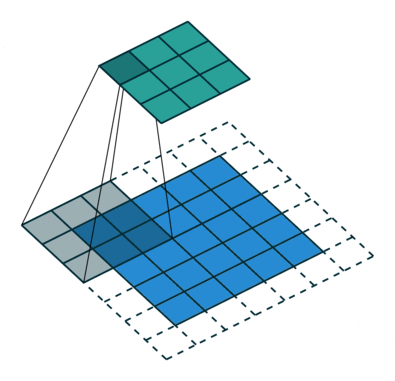

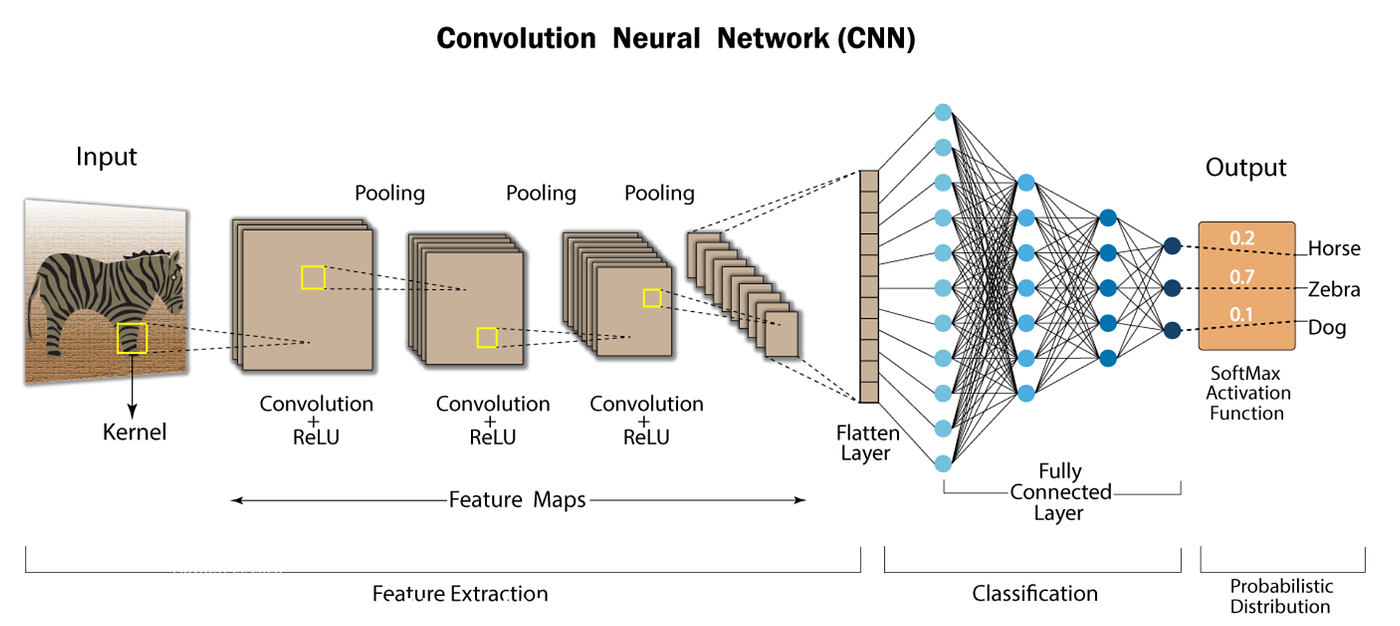

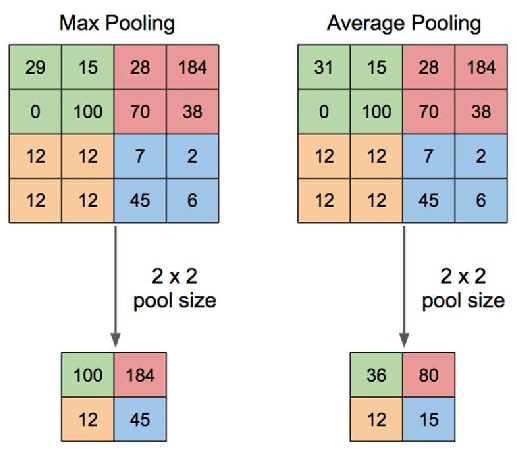

*All images has been collected from sources with CC BY-NC 4.0 license.*

In [21]:
class Classifier(nn.Module):
  def __init__(self, c_in = 1, output_dim = 10):
    super().__init__()
    self.layer1 = nn.Conv2d(c_in, 16, kernel_size = 7)
    self.layer2 = nn.Conv2d(16, 32, kernel_size = 5)
    self.layer3 = nn.Conv2d(32, 64, kernel_size = 3)
    self.layer4 = nn.Conv2d(64, output_dim, kernel_size = 3)

  def forward(self, x):
    x = F.tanh(self.layer1(x))
    x = F.tanh(self.layer2(x))
    x = F.tanh(self.layer3(x))
    x = self.layer4(x)
    x = F.avg_pool2d(x, kernel_size=(x.shape[-2], x.shape[-1])).squeeze()

    return x

Training this on CPU will be hard. So change your runtime to GPU. Go to `Runtime` from the menu bar. Select  `Change runtime type`. Under `Hardware accelerator`, tick `T4 GPU`. Then run the next cell.

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
dataset = mnist.load_data()
(x_train, y_train), (x_test, y_test) = dataset

x_train = x_train/255.0
x_test = x_test/255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = (x_train - x_train.mean(axis = 0, keepdims = True))/(x_train.std(axis = 0, keepdims = True) + 1e-4)
x_test = (x_test - x_test.mean(axis = 0, keepdims = True))/(x_test.std(axis = 0, keepdims = True) + 1e-4)

In [24]:
x_train, y_train = torch.tensor(x_train, device = device), torch.tensor(y_train, device = device)
x_test, y_test = torch.tensor(x_test, device = device), torch.tensor(y_test, device = device)

In [25]:
x_train = x_train.unsqueeze(1)
x_test = x_test.unsqueeze(1)

Now, you can try out the previous training cycle, but it will crash the session as you will run out of RAM.

In [26]:
# classifier = Classifier().to(device)
# optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.01)
# loss_fn = nn.CrossEntropyLoss()

# epochs = 100

# for epoch in range(epochs):
#   y_predict = classifier(x_train).squeeze()
#   loss = loss_fn(y_predict, y_train_one_hot)
#   predicted_classes = y_predict.argmax(dim=1)
#   correct = (predicted_classes == y_train).sum().item()

#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   if (epoch+1)%10 == 0:
#     print(f"Epoch {epoch + 1} | Loss - {loss} | Accuracy - {correct/x_train.shape[0]}")

# classifier.eval()
# y_predict = classifier(x_test)
# predicted_classes = y_predict.argmax(dim=1)
# correct = (predicted_classes == y_test).sum().item()
# print(f"\nTest loss - {loss_fn(y_predict, y_test_one_hot)} | Accuracy - {correct/x_test.shape[0]}")

As it turns out, to no one's surprise, neural networks are very heavy in terms of RAM usage. The RAM usage is directly proportional to the number of samples used. So, if the model is too big, the device struggles to fit all the samples in the RAM. This is why we have to train on mini-batches of samples instead of training on all the samples at the same time. There are additional advantages such as faster convergence and avoidance of local minima. However the curve fitting might become difficult owing to loss of generalizability.

In [ ]:
batch_size = 8192

batch_len = int(np.ceil(x_train.shape[0]/batch_size))

classifier = Classifier().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

epochs = 100

for epoch in range(epochs):
    total_loss = 0
    epoch_correct = 0

    for minibatch in range(batch_len):
        start = minibatch * batch_size
        end = (minibatch + 1) * batch_size if minibatch != batch_len - 1 else x_train.shape[0]

        x_batch = x_train[start:end]
        y_batch = y_train[start:end]

        y_predict = classifier(x_batch)
        loss = loss_fn(y_predict, y_batch)

        predicted_classes = y_predict.argmax(dim=1)
        correct = (predicted_classes == y_batch).sum().item()
        epoch_correct += correct

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / batch_len
        accuracy = epoch_correct / x_train.shape[0]
        print(f"Epoch {epoch + 1} | Loss - {avg_loss:.4f} | Accuracy - {accuracy:.4f}")

In [ ]:
classifier.eval()
y_predict = classifier(x_test)
predicted_classes = y_predict.argmax(dim=1)
correct = (predicted_classes == y_test).sum().item()
print(f"\nTest loss - {loss_fn(y_predict, y_test)} | Accuracy - {correct/x_test.shape[0]}")


Test loss - 0.04310440644621849 | Accuracy - 0.9862


Now go back through the code and check which model did the best. And you can draw the conclusions yourself.

If you are interested in how convolutional networks see the world you might consider going through -

*   Transformations on the image - https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/
*   Layer activation - https://arxiv.org/abs/1506.06579

The takeaway is that earlier layers learn low level features and later layers learn high level features. The visualization may not make much sense because remember that the earlier layers change the input images quite a bit and for extracting the high level features, the filters have to adjust. While simplistic networks may give more human interpretable high level features, complicated networks may fail to do so.